created at 14_11_2023 
equation: 
 d/dt (T(t)) = r (Tenv - T(t)) 
Exact solution: 
 T(t) = Tenv + (T(0)-Tenv) exp(r.t) 
 
Initial condition:
    When t= 0, T(t) = T(0) = 100 degree celsius
    Tenv = 25 degree celsius 
    cooling rate = .005

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
torch.manual_seed(123)  

def calculate_temperature(T_0, T_env, r, time):
    temperature_at_t = T_env + (T_0 - T_env) * torch.exp(-r * time)
    return temperature_at_t



torch.Size([900, 1]) torch.Size([900, 1])
torch.Size([900, 1])
torch.Size([900, 1])
torch.Size([200, 1])
torch.Size([200, 1])


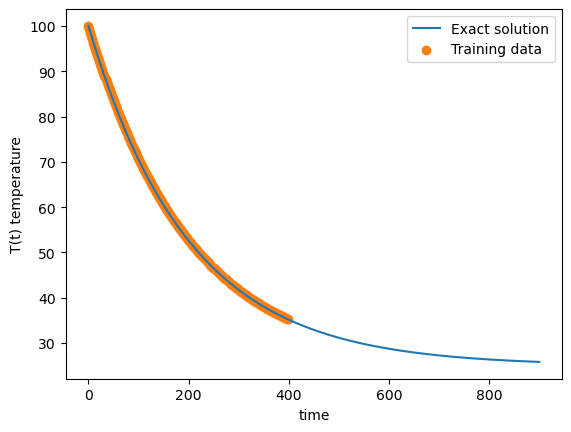

In [2]:
T_env = 25  # Environment temperature
T_0 = 100   # Initial temperature
r = 0.005     # Rate (adjusted for faster cooling)

time = torch.linspace(0, 900, 900).view(-1,1)
temperature_at_t = calculate_temperature(100,25,0.005,time).view(-1,1)
print(time .shape, temperature_at_t.shape)

print(time.size())
print(temperature_at_t .size())
time_slice = time[0:400:2]
temperature_at_t_slice = temperature_at_t[0:400:2]
print(time_slice.size()) 
print(temperature_at_t_slice.size())
#print(time_slice.shape, temperature_at_t_slice.shape)

plt.figure()
plt.plot(time ,temperature_at_t, label="Exact solution")
plt.scatter(time_slice, temperature_at_t_slice, color="tab:orange", label="Training data")
plt.xlabel('time')
plt.ylabel('T(t) temperature') 
plt.legend()
plt.savefig('exact_solution_temp_plot.png', dpi=300)  # 'example_plot.png' is the file name; dpi sets the resolution
plt.show()

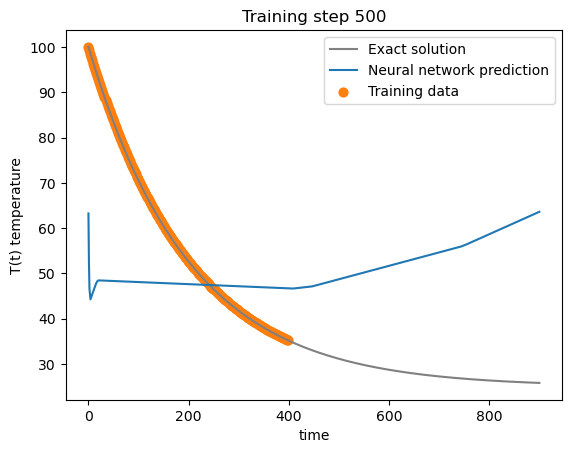

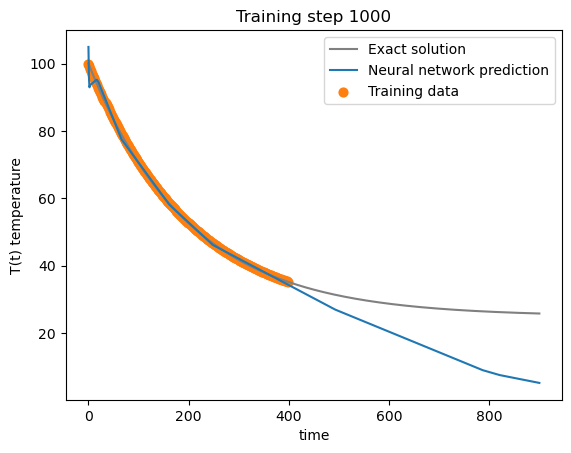

In [3]:

torch.manual_seed(123)
# Define a neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Additional hidden layer
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)  # Activation function after the additional hidden layer
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Initialize the model
input_size = 1  # Time as input
hidden_size = 32 # Number of neurons in the hidden layer
output_size = 1  # Predicted temperature as output

model = SimpleNN(input_size, hidden_size, output_size)


#criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


#files = []
for i in range(1000):
    optimizer.zero_grad()
    yh = model(time_slice)
    loss = torch.mean((yh-temperature_at_t_slice)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    #if (i + 1) % 200 == 0:
        #print(f'i [{i+1}/{1000}], Loss: {loss.item()}')

    # plot the result as training progresses
    if (i+1) % 10 == 0:

        yh = model(time).detach()

        plt.plot(time,temperature_at_t, color="grey", label="Exact solution")
        plt.plot(time,yh, color="tab:blue", label="Neural network prediction")
        plt.scatter(time_slice, temperature_at_t_slice, s=40, color="tab:orange", label='Training data') 
        #plt.text(1.00,1.00,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
        plt.title(f"Training step {i + 1}")
        plt.xlabel('time') 
        plt.ylabel('T(t) temperature') 
        plt.legend()
        plt.savefig('NN_plot.png', dpi=300)  # 'example_plot.png' is the file name; dpi sets the resolution 
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")

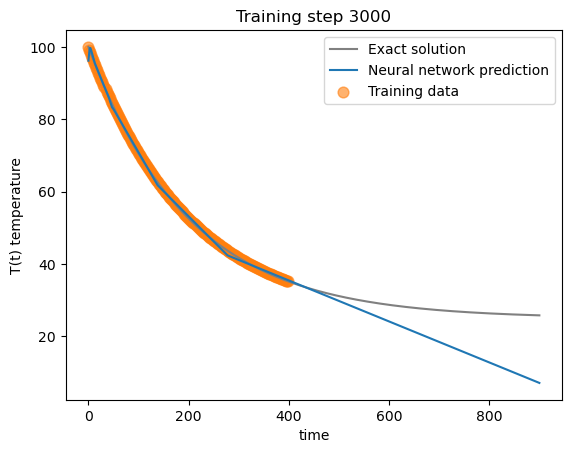

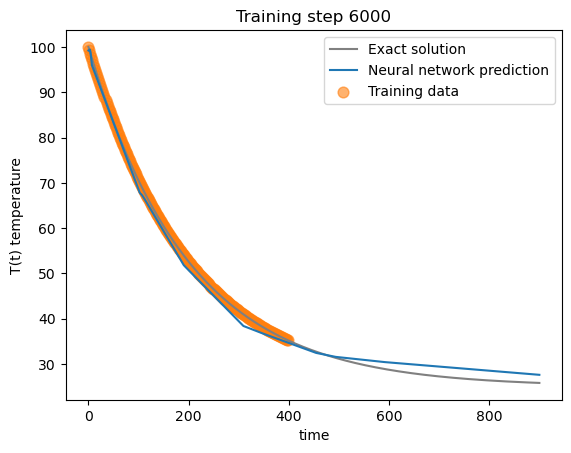

In [4]:
torch.manual_seed(123)
time_physics = torch.linspace(0,900,1600).view(-1,1).requires_grad_(True)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

#files = []
for i in range(6000):
    optimizer.zero_grad()

    # compute the "data loss"
    yh = model(time_slice)
    loss1 = torch.mean((yh-temperature_at_t_slice)**2)# use mean squared error

    # compute the "physics loss"
    yhp = model(time_physics)
    dx  = torch.autograd.grad(yhp, time_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    physics = dx - r * (T_env - yhp)
    loss2 = (1e-3*torch.mean(physics**2))  # 2,3 works well  

    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()
    #if (i + 1) % 2000 == 0:
        #print(f'i [{i+1}/{12000}], Loss: {loss.item()}')

    # plot the result as training progresses
    if (i+1) % 500 == 0:

        yh = model(time).detach()
        #xp = time_physics.detach()
        plt.plot(time,temperature_at_t, color="grey",label="Exact solution")
        plt.plot(time,yh, color="tab:blue", label="Neural network prediction")
        plt.scatter(time_slice, temperature_at_t_slice, s=60, color="tab:orange", alpha=0.6, label='Training data') 
        plt.title(f"Training step {i + 1}")
        plt.xlabel('time')
        plt.ylabel('T(t) temperature') 
        plt.legend()
        
        plt.savefig('PINN_plot.png', dpi=300)  # 'example_plot.png' is the file name; dpi sets the resolution 
        if (i+1) % 3000 == 0: plt.show()
        else: plt.close("all")





#even ckecning the collocation number and loss , no fevarable outcome visible for train data 300

In [5]:
# 450 data points, 1200 collocation points, 2k 
# 400 data data points 1600, 6k 2,3
#